#### Naive Bayes: Classifying mathematical formulas

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 
import matplotlib.colors as colors

from pathlib import Path

import sklearn
from sklearn.utils import resample # downsample dataset
from sklearn.model_selection import train_test_split # split to training and testing datasets
from sklearn.model_selection import GridSearchCV, cross_validate # cross validation
#from sklearn.preprocessing import scale # scale and center data
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.pipeline import make_pipeline

import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn

#### Import Data

In [2]:
data_p = Path("data/") / "bin_class_data_TOKENIZED_V1.csv"
data = pd.read_csv(data_p)
print("Number of data rows: {}".format(data.shape[0]))
data.head()


Number of data rows: 10981


,mtype,tokens,label
0,SET,"['\\{', 'a', '\\}']",1
1,SCAL,"['3', 'r']",1
2,FUNC,['f'],1
3,SCAL,"['\\binom', '{', '4', '}', '{', '4', '}']",1
4,SCAL,['1'],1


#### Dataset Statistics

Data types:
mtype     object
tokens    object
label      int64
dtype: object

There are 2 comment types: [1 0]


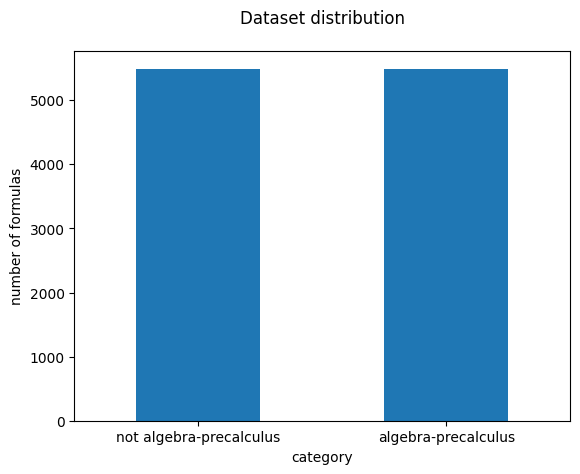

In [3]:
print(f"Data types:\n{data.dtypes}\n")
print(f"There are {len(data['label'].unique())} comment types: {data['label'].unique()}")

data.groupby("label").label.count().plot.bar(ylim=0)
plt.xticks([0,1],['not algebra-precalculus', 'algebra-precalculus'], rotation=0)
plt.xlabel("category")
plt.ylabel("number of formulas")
plt.title("Dataset distribution", pad=20)
plt.show()

#### Preprocessing


In [4]:
def preprocess_data(corpus,
                    irrelevant_features=["mtype",]):
    # drop irrelevant columns
    corpus.drop(irrelevant_features, inplace=True, axis=1)

    # filter strings
    def process_cell(cell_str):
        stripped_f_str = cell_str[1:-1].replace("\\\\", "\\")
        f_list = stripped_f_str.split(",")
        f_list = [token.replace("'", "").replace(" ", "") for token in f_list]
        f_list = ["{" if token == "\\{" else token for token in f_list]
        f_list = ["}" if token == "\\}" else token for token in f_list]
        cell_str = " ".join(f_list)
        return cell_str

    corpus["tokens"] = corpus["tokens"].map(process_cell)

In [5]:
preprocess_data(data)
data.head()

,tokens,label
0,{ a },1
1,3 r,1
2,f,1
3,\binom { 4 } { 4 },1
4,1,1


#### Representation 1

In [6]:
# binary based vectorizer
vectorizer = CountVectorizer(binary=True, token_pattern = r"[^\s]+", max_df=0.95) #max_features=10000, tokenizer=lambda doc: doc)
bow1 = vectorizer.fit_transform(data["tokens"])
feature_names = vectorizer.get_feature_names_out() 
print(feature_names)
print(len(feature_names))

['!' '(' ')' '*' '+' '-' '/' '0' '1' '2' '3' '4' '5' '6' '7' '8' '9' ':'
 '=' '[' '\\arccos' '\\arcsin' '\\arctan' '\\binom' '\\cap' '\\cdot'
 '\\circ' '\\colon' '\\cos' '\\cosh' '\\cot' '\\cup' '\\dbinom' '\\dfrac'
 '\\div' '\\exp' '\\frac' '\\ln' '\\log' '\\mathbb' '\\mathbb{c}'
 '\\mathbb{n}' '\\mathbb{q}' '\\mathbb{r}' '\\mathbb{z}' '\\rightarrow'
 '\\sin' '\\sinh' '\\tanh' '\\tfrac' '\\times' '\\to' '\\varnothing' ']'
 '^' 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o' 'p' 'q'
 'r' 's' 't' 'u' 'v' 'w' 'x' 'y' 'z' '{' '}']
83


In [7]:
print("Formula String: ",data["tokens"][0])
print("Vector Representation: ",bow1[0].toarray())
print("Formula String: ",data["tokens"][3])
print("Vector Representation: ",bow1[3].toarray())

Formula String:  { a }
Vector Representation:  [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 1 1]]
Formula String:  \binom { 4 } { 4 }
Vector Representation:  [[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 1 1]]


#### Representation 2

In [8]:
# count based vectorizer
vectorizer2 = CountVectorizer(binary=False, token_pattern = r"[^\s]+", max_df=0.95) # max_df=0.95
bow2 = vectorizer2.fit_transform(data["tokens"])
feature_names = vectorizer2.get_feature_names_out()
print(feature_names)
print(len(feature_names))

['!' '(' ')' '*' '+' '-' '/' '0' '1' '2' '3' '4' '5' '6' '7' '8' '9' ':'
 '=' '[' '\\arccos' '\\arcsin' '\\arctan' '\\binom' '\\cap' '\\cdot'
 '\\circ' '\\colon' '\\cos' '\\cosh' '\\cot' '\\cup' '\\dbinom' '\\dfrac'
 '\\div' '\\exp' '\\frac' '\\ln' '\\log' '\\mathbb' '\\mathbb{c}'
 '\\mathbb{n}' '\\mathbb{q}' '\\mathbb{r}' '\\mathbb{z}' '\\rightarrow'
 '\\sin' '\\sinh' '\\tanh' '\\tfrac' '\\times' '\\to' '\\varnothing' ']'
 '^' 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o' 'p' 'q'
 'r' 's' 't' 'u' 'v' 'w' 'x' 'y' 'z' '{' '}']
83


In [9]:
print("Formula String: ",data["tokens"][0])
print("Vector Representation: ",bow2[0].toarray())
print("Formula String: ",data["tokens"][3])
print("Vector Representation: ",bow2[3].toarray())

Formula String:  { a }
Vector Representation:  [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 1 1]]
Formula String:  \binom { 4 } { 4 }
Vector Representation:  [[0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 2 2]]


#### Representation 3

In [10]:
# count based vectorizer
vectorizer3 = CountVectorizer(token_pattern = r"[^\s]+", tokenizer=lambda doc: doc, ngram_range=(2,2), max_df=0.95) # max_df=0.95
bow3 = vectorizer3.fit_transform(data["tokens"])
feature_names = vectorizer3.get_feature_names_out()
print(feature_names)
print(len(feature_names))

['   ' '  !' '  (' '  )' '  *' '  +' '  -' '  /' '  0' '  1' '  2' '  3'
 '  4' '  5' '  6' '  7' '  8' '  9' '  :' '  =' '  [' '  \\' '  ]' '  ^'
 '  a' '  b' '  c' '  d' '  e' '  f' '  g' '  h' '  i' '  j' '  k' '  l'
 '  m' '  n' '  o' '  p' '  q' '  r' '  s' '  t' '  u' '  v' '  w' '  x'
 '  y' '  z' '  {' '  }' '!  ' '(  ' ')  ' '*  ' '+  ' '-  ' '/  ' '0  '
 '1  ' '2  ' '3  ' '4  ' '5  ' '6  ' '7  ' '8  ' '9  ' ':  ' '=  ' '[  '
 '\\ a' '\\ b' '\\ c' '\\ d' '\\ e' '\\ f' '\\ l' '\\ m' '\\ r' '\\ s'
 '\\ t' '\\ v' ']  ' '^  ' 'a  ' 'a c' 'a n' 'a p' 'a r' 'a t' 'b  ' 'b b'
 'b i' 'b {' 'c  ' 'c a' 'c c' 'c d' 'c i' 'c o' 'c s' 'c t' 'c u' 'c }'
 'd  ' 'd b' 'd f' 'd i' 'd o' 'e  ' 'e s' 'e x' 'f  ' 'f r' 'g  ' 'g h'
 'h  ' 'h b' 'h i' 'h t' 'i  ' 'i g' 'i m' 'i n' 'i r' 'i v' 'j  ' 'k  '
 'l  ' 'l n' 'l o' 'm  ' 'm a' 'm e' 'n  ' 'n g' 'n h' 'n o' 'n }' 'o  '
 'o g' 'o l' 'o m' 'o n' 'o s' 'o t' 'o w' 'p  ' 'q  ' 'q }' 'r  ' 'r a'
 'r c' 'r i' 'r n' 'r o' 'r r' 'r }' 's  ' 's h' '

/home/paul_d/Sources/sem_math_bin_classifiers/sem_mcl_env/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [11]:
print("Formula String: ",data["tokens"][0])
print("Vector Representation: ",bow3[0].toarray())
print("Formula String: ",data["tokens"][3])
print("Vector Representation: ",bow3[3].toarray())

Formula String:  { a }
Vector Representation:  [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
  0 0 0 0 0 0]]
Formula String:  \binom { 4 } { 4 }
Vector Representation:  [[0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0
  0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0
  1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2
  0 0 0 0 0 1]]


#### Representation 4

In [12]:
# count based vectorizer
vectorizer4 = TfidfVectorizer(use_idf=True, token_pattern = r"[^\s]+", max_df=0.95) # max_df=0.95
bow4 = vectorizer4.fit_transform(data["tokens"])
feature_names = vectorizer4.get_feature_names_out()
print(feature_names)
print(len(feature_names))

['!' '(' ')' '*' '+' '-' '/' '0' '1' '2' '3' '4' '5' '6' '7' '8' '9' ':'
 '=' '[' '\\arccos' '\\arcsin' '\\arctan' '\\binom' '\\cap' '\\cdot'
 '\\circ' '\\colon' '\\cos' '\\cosh' '\\cot' '\\cup' '\\dbinom' '\\dfrac'
 '\\div' '\\exp' '\\frac' '\\ln' '\\log' '\\mathbb' '\\mathbb{c}'
 '\\mathbb{n}' '\\mathbb{q}' '\\mathbb{r}' '\\mathbb{z}' '\\rightarrow'
 '\\sin' '\\sinh' '\\tanh' '\\tfrac' '\\times' '\\to' '\\varnothing' ']'
 '^' 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o' 'p' 'q'
 'r' 's' 't' 'u' 'v' 'w' 'x' 'y' 'z' '{' '}']
83


In [13]:
print("Formula String: ",data["tokens"][0])
print("Vector Representation: ",bow4[0].toarray())
print("Formula String: ",data["tokens"][3])
print("Vector Representation: ",bow4[3].toarray())

Formula String:  { a }
Vector Representation:  [[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.57624899 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.57790012 0.57790012]]
Formula String:  \binom { 4 } { 4 }
Vector Representation:  [[0.         0.         0.         0.         0.      

#### Model

In [16]:
def split_data(features, labels):
    return train_test_split(features,labels, test_size=0.3,random_state=42,shuffle=True)

"""
def save_model(model):
    now = datetime.datetime.now()
    model_output_path = "saved_models/"+model.__class__.__name__.lower()+"_"+str(now.minute)+"-"+str(now.second)+".joblib"
    joblib.dump(model, open(model_output_path, 'wb+'))
"""

    
def report(model, best_model, X_test, y_test, labels):
    print(f"Best parameters set {model.best_params_} with accuracy {model.best_score_}")
    y_predict = best_model.predict(X_test)
    
    labels = sorted(list(set(labels)))
    print("\nConfusion matrix:")
    cm = confusion_matrix(y_test, y_predict, labels=labels) # lables=clf.classes_
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot()
    plt.show()
    
    print("\nClassification report:")
    print(classification_report(y_test, y_predict))
    
    print("\nAccuracy: {}%".format(accuracy_score(y_test, y_predict)*100))
    print("Precision: {}%".format(sklearn.metrics.precision_score(y_test, y_predict)*100))
    print("Recall: {}%".format(sklearn.metrics.recall_score(y_test, y_predict)*100))

    
def train_nb_classifier(features, labels):
    # split data
    X_train, X_test, y_train, y_test = split_data(features, labels)

    param = {'alpha': [0.01, 0.1, 0.5, 1.0, 10.0, ],
             'fit_prior': [True, False]
            }

    clf = GridSearchCV(MultinomialNB(), param, cv=5, n_jobs=2, verbose=0)
    
    clf.fit(X_train, y_train)
    nb_clf = clf.best_estimator_
    
    # save model to disk
    #save_model(nb_clf)
    
    # show test report
    report(clf, nb_clf, X_test, y_test, labels)

#### 1. Using binary BOW representation

Best parameters set {'alpha': 0.5, 'fit_prior': False} with accuracy 0.609678388226943

Confusion matrix:


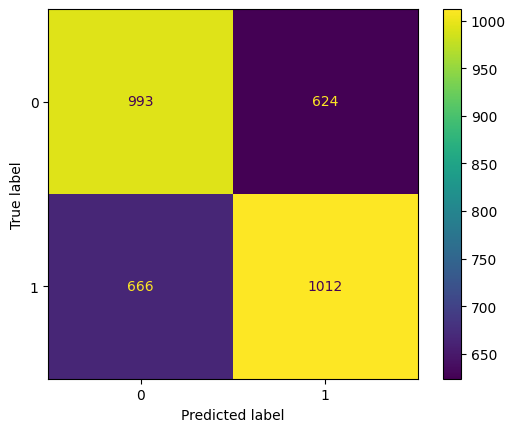


Classification report:
              precision    recall  f1-score   support

           0       0.60      0.61      0.61      1617
           1       0.62      0.60      0.61      1678

    accuracy                           0.61      3295
   macro avg       0.61      0.61      0.61      3295
weighted avg       0.61      0.61      0.61      3295


Accuracy: 60.849772382397575%
Precision: 61.858190709046454%
Recall: 60.30989272943981%


In [17]:
train_nb_classifier(bow1, np.asarray(data["label"]))

#### 2. Using non-binary BOW representation

Best parameters set {'alpha': 0.5, 'fit_prior': True} with accuracy 0.6072062087071144

Confusion matrix:


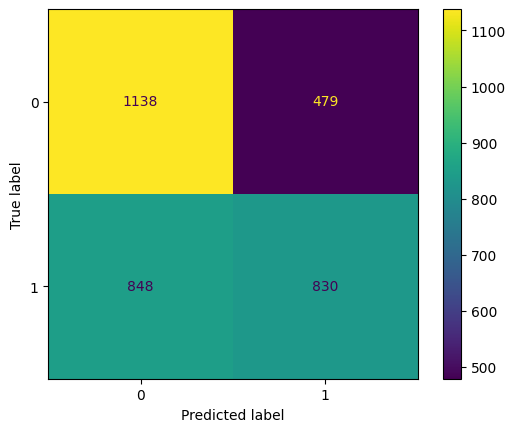


Classification report:
              precision    recall  f1-score   support

           0       0.57      0.70      0.63      1617
           1       0.63      0.49      0.56      1678

    accuracy                           0.60      3295
   macro avg       0.60      0.60      0.59      3295
weighted avg       0.60      0.60      0.59      3295


Accuracy: 59.7268588770865%
Precision: 63.40718105423988%
Recall: 49.463647199046484%


In [18]:
train_nb_classifier(bow2, np.asarray(data["label"]))

#### 3. Using B-of-2Grams representation

Best parameters set {'alpha': 0.5, 'fit_prior': False} with accuracy 0.5922452077197654

Confusion matrix:


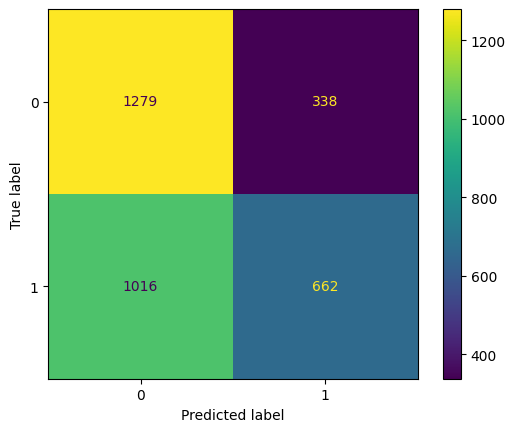


Classification report:
              precision    recall  f1-score   support

           0       0.56      0.79      0.65      1617
           1       0.66      0.39      0.49      1678

    accuracy                           0.59      3295
   macro avg       0.61      0.59      0.57      3295
weighted avg       0.61      0.59      0.57      3295


Accuracy: 58.907435508345976%
Precision: 66.2%
Recall: 39.45172824791419%


In [19]:
train_nb_classifier(bow3, np.asarray(data["label"]))

#### 4. Using TF-IDF representation

Best parameters set {'alpha': 0.5, 'fit_prior': True} with accuracy 0.6098091040845111

Confusion matrix:


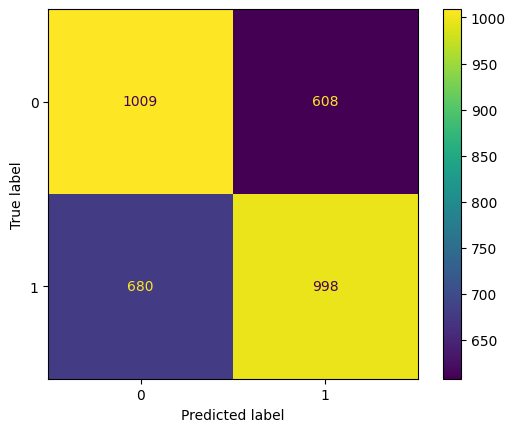


Classification report:
              precision    recall  f1-score   support

           0       0.60      0.62      0.61      1617
           1       0.62      0.59      0.61      1678

    accuracy                           0.61      3295
   macro avg       0.61      0.61      0.61      3295
weighted avg       0.61      0.61      0.61      3295


Accuracy: 60.91047040971168%
Precision: 62.14196762141968%
Recall: 59.475566150178786%


In [20]:
train_nb_classifier(bow4, np.asarray(data["label"]))